Bibliotheken importieren

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import layers, models, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TEMPORÄR: PIL/Pillow konfigurieren, um beschädigte Bilder ignorieren

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Datensatz laden

In [29]:
# pfad definieren
base_dir = 'dataset'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# bildgröße definieren
img_width, img_height = 350, 350
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# daten laden
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


Datenvisualisierung

Training: 30250 Bilder
Validierung: 6300 Bilder
Test: 6300 Bilder


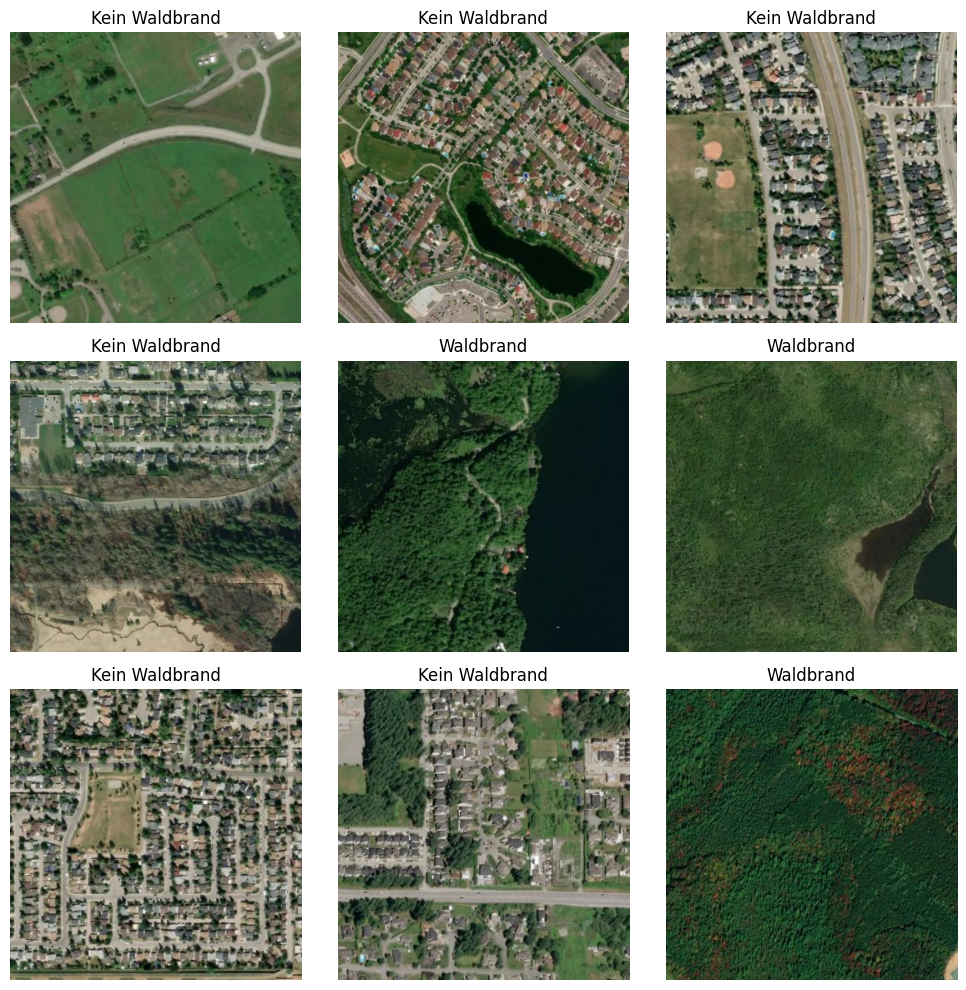

In [30]:
# anzahl der bilder und klassen
print(f"Training: {train_generator.samples} Bilder")
print(f"Validierung: {validation_generator.samples} Bilder")
print(f"Test: {test_generator.samples} Bilder")

# beispiel bilder anzeigen
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i])
        plt.title('Waldbrand' if label_batch[i] == 1 else 'Kein Waldbrand')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

image_batch, label_batch = next(train_generator)
show_batch(image_batch, label_batch)

CNN erstellen

In [31]:
def create_custom_cnn():
    model = models.Sequential()

    # input layer
    model.add(layers.Input(shape=(img_width, img_height, 3)))

    # architektur
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

custom_model = create_custom_cnn()
custom_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 348, 348, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 174, 174, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 172, 172, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 86, 86, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 84, 84, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 42, 42, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 40, 40, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    26,214,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,456,257 (100.92 MB)

 Trainable params: 26,456,257 (100.92 MB)

 Non-trainable params: 0 (0.00 B)

Modelltraining

In [32]:
# trainingsparameter
epochs = 20
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

# callback für early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

# cnn trainieren
custom_history = custom_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)

Epoch 1/20
 76/945 ━━━━━━━━━━━━━━━━━━━━ 32:41 2s/step - accuracy: 0.7262 - loss: 0.5287 - precision_3: 0.7860 - recall_3: 0.5996

KeyboardInterrupt: 

Speichern

In [ ]:
model_save_path = 'waldbrand_classifier.keras'
custom_model.save(model_save_path)
print(f"Modell gespeichert unter: {model_save_path}")

Bewertung

In [ ]:
# plotten der ergebnisse
def plot_history(history, title):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{title} - Genauigkeit')
    plt.ylabel('Genauigkeit')
    plt.xlabel('Epoche')
    plt.legend(['Training', 'Validierung'], loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{title} - Verlust')
    plt.ylabel('Verlust')
    plt.xlabel('Epoche')
    plt.legend(['Training', 'Validierung'], loc='upper right')

    plt.tight_layout()
    plt.show()

plot_history(custom_history, 'Eigenes CNN')
plot_history(resnet_history, 'ResNet50 Transfer Learning')
plot_history(augmented_history, 'Eigenes CNN mit Data Augmentation')

# modellbewertung auf dem testdatensatz
def evaluate_model(model, generator, title):
    # prediction
    predictions = model.predict(generator, steps=generator.samples // batch_size + 1)
    y_pred = (predictions > 0.5).astype("int32")

    # true label
    y_true = generator.classes

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {title}')
    plt.ylabel('Wahre Klasse')
    plt.xlabel('Vorhergesagte Klasse')
    plt.show()

    print(f"\nKlassifikationsbericht - {title}:")
    print(classification_report(y_true, y_pred, target_names=['Kein Waldbrand', 'Waldbrand']))

evaluate_model(custom_model, test_generator, 'Eigenes CNN')
evaluate_model(resnet_model, test_generator, 'ResNet50 Transfer Learning')